In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Create Target Signal ###

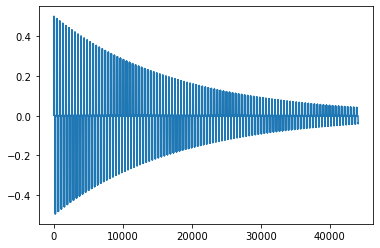

In [2]:
fs = 44100
k = 1.0 / fs
dur = fs

c = 200
s0 = 2.5

h = c * k
N = int(np.floor(1/h))
h = (1 / N)

lambdaSq = pow(c,2) * pow(k,2) / pow(h,2)

state_matrix = np.zeros((N, 2))

width = int(np.floor(N / 5))
excitationRange = np.arange(0, width)
state_matrix[excitationRange + int(np.floor(N/2)), 0] = np.hanning(width)
state_matrix[excitationRange + int(np.floor(N/2)), 1] = state_matrix[excitationRange + int(np.floor(N/2)), 0]

uNext = np.zeros(N)

out = np.zeros(dur)
outPos = int(np.floor(N/2))

def _cat(a, b):
    return np.vstack((a, b))

for n in range(dur):
    uNext = np.zeros(N)
    for l in range(1, len(state_matrix) - 1):
        uNext[l] = (2 * state_matrix[l, 0] - state_matrix[l, 1] + lambdaSq * (state_matrix[l+1, 0] - 2 * state_matrix[l, 0] + state_matrix[l-1, 0]) + s0 * k * state_matrix[l, 1]) / (1 + s0 * k)
    
    out[n] = uNext[outPos]

    state_matrix[:,1] = state_matrix[:, 0]
    state_matrix[:,0] = uNext

plt.plot(out)

from scipy.io.wavfile import write
write("string_test.wav", fs, out.astype(np.float32))

In [58]:
from scipy.io.wavfile import write
write("string.wav", fs, out.astype(np.float32))

### Training Scripts ###

In [3]:
from math import pi
import numpy as np
import torch
from torch.nn import Module, ModuleList, Parameter
from torch import FloatTensor
from numpy.random import uniform

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# define duration of target and fdtd method
duration = 2205

In [11]:
torch.set_default_dtype(torch.float64)

#@torch.jit.script
def calc_gridpoints(u_mat, lambdaSq, s0, k, l):
    return (2 * u_mat[l, 0] - u_mat[l, 1] + lambdaSq * (u_mat[l+1, 0] - 2 * u_mat[l, 0] + u_mat[l-1, 0]) + s0 * k * u_mat[l, 1]) / (1 + s0 * k)

class Wave1DCell(Module):
    def __init__(self):
        super(Wave1DCell, self).__init__()
        self.s0 = Parameter(FloatTensor([uniform(0.0, 3.0)]))

    def _cat(self, vectors):
        return torch.cat([v_.unsqueeze(-1) for v_ in vectors], dim=-1)
        
    def forward(self, u_mat, lambdaSq, k):

        uNext = torch.zeros(len(u_mat), device=torch.device(device))
        for l in range(1, len(u_mat) - 1):
            uNext[l] = calc_gridpoints(u_mat, lambdaSq, self.s0, k, l)
    
        u_mat = self._cat([uNext, u_mat[:, 0]]).to(device)        
        return uNext, u_mat

    def init_states(self, N):
        v = torch.zeros(N, 2,  device=torch.device(device))
        return v

class Wave1D(Module):
    def __init__(self):
        super(Wave1D, self).__init__()
        self.cell = Wave1DCell()

    def forward(self):

        fs = 44100
        k = 1.0 / fs
        dur = duration
        c = 200
        h = c * k
        N = int(np.floor(1/h))
        h = (1 / N)
        lambdaSq = pow(c,2) * pow(k,2) / pow(h,2)

        state_matrix = self.cell.init_states(N)

        width = int(np.floor(N / 5))
        excitationRange = torch.arange(0, width)
        state_matrix[excitationRange + int(np.floor(N/2)), 0] = torch.hann_window(width,  device=torch.device(device))
        state_matrix[excitationRange + int(np.floor(N/2)), 1] = state_matrix[excitationRange + int(np.floor(N/2)), 0]

        outPos = int(np.floor(N/2))

        output = torch.zeros(dur,  device=torch.device(device))

        for n in range(dur):
            #print("n")
            uNext, state_matrix = self.cell(state_matrix, lambdaSq, k)
            output[n] = uNext[outPos]
            
        return output.reshape(1, -1, 1)

In [12]:
import librosa
target, sr = librosa.load("string_test.wav", mono=True, sr=None)
target = target[:duration]
print(sr)

44100


In [13]:
model = Wave1D().to(device)

In [14]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DIIRDataSet(Dataset):
    def __init__(self, target, sequence_length):
        self.target = target
        self._sequence_length = sequence_length
        self.target_sequence = self.wrap_to_sequences(self.target, self._sequence_length)
        self._len = self.target_sequence.shape[0]

    def __len__(self):
        return self._len

    def __getitem__(self, index):
        return {'target': self.target_sequence[index, :, :]}

    def wrap_to_sequences(self, data, sequence_length):
        num_sequences = int(np.floor(data.shape[0] / sequence_length))
        truncated_data = data[0:(num_sequences * sequence_length)]
        wrapped_data = truncated_data.reshape((num_sequences, sequence_length, 1))
        return np.float64(wrapped_data)

batch_size = 512
sequence_length = len(target)

loader = DataLoader(dataset=DIIRDataSet(target, sequence_length), batch_size=batch_size, shuffle = False)
print(next(iter(loader))['target'].size())

torch.Size([1, 2205, 1])


In [15]:
from torch.optim import Adam
from time import process_time

criterion = torch.nn.MSELoss().to(device)

n_epochs = 100
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

losses = []
epoch_times = []

def train(criterion, model, loader, optimizer):
    model.train()
    start_time = process_time()
    device = next(model.parameters()).device
    total_loss = 0

    for batch in loader:
        target_seq_batch = batch['target'].to(device)
                
        optimizer.zero_grad()
        predicted_output = model()
        predicted_output = predicted_output.to(device)
        
        loss = criterion(target_seq_batch, predicted_output.reshape(1, -1, 1)) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    total_loss /= len(loader)
    losses.append(total_loss)
    current_time = process_time()
    epoch_times.append(current_time-start_time)
    epoch_time = str(round((current_time-start_time), 2))

    
    return total_loss, epoch_time

In [16]:
#torch.autograd.set_detect_anomaly(True)

for epoch in range(n_epochs):
    loss, epoch_time = train(criterion, model, loader, optimizer)
    print("Epoch {} -- Loss {:3E} -- Time {}".format(epoch, loss, epoch_time))

KeyboardInterrupt: 

In [77]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

cell.s0 tensor([0.5050], dtype=torch.float32)
